![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Redes neuronales
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [7]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [8]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Procesamiento de datos

### CountVectorizer

In [8]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [9]:

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(tokenize_and_lemmatize)

### CountVectorizer + Lematización

In [10]:
vect = CountVectorizer(max_features=1000)

X_dtm = vect.fit_transform(dataTraining['plot_lemmatized'])
print(X_dtm.shape)

(7895, 1000)


### TF-IDF + Lematización

In [11]:
# Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)

# Ajustar y transformar los datos preprocesados
tfidf_matrix = vectorizer.fit_transform(dataTraining['plot_lemmatized'])

# Convertir la matriz TF-IDF a un array
tfidf_array = tfidf_matrix.toarray()

# Verificar la matriz TF-IDF
print(tfidf_array.shape)

(7895, 10000)


## Modelamiento

In [12]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [13]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7814848840981609

#### Lemtatización  TF-IDF + LSTM

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

In [15]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp


# Creación de hiperparámetros
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([50,100,150,200]))
HP_NUM_1_UNITS = hp.HParam('num_units', hp.Discrete([50,100,150,200]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [16]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(tfidf_array, y_genres, test_size=0.4, random_state=312)

In [17]:
K.clear_session()
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(250,input_shape=(tfidf_array.shape[1],)),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(len(le.classes_), activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )
  model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test, y_test)) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

In [18]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [19]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'num_units': 50, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/10
149/149 - 10s - loss: 0.3404 - accuracy: 0.2692 - val_loss: 0.3091 - val_accuracy: 0.3281 - 10s/epoch - 66ms/step
Epoch 2/10
149/149 - 6s - loss: 0.2690 - accuracy: 0.4275 - val_loss: 0.2780 - val_accuracy: 0.3775 - 6s/epoch - 41ms/step
Epoch 3/10
149/149 - 7s - loss: 0.2151 - accuracy: 0.4839 - val_loss: 0.2806 - val_accuracy: 0.3629 - 7s/epoch - 49ms/step
Epoch 4/10
149/149 - 7s - loss: 0.1863 - accuracy: 0.4760 - val_loss: 0.2904 - val_accuracy: 0.3322 - 7s/epoch - 46ms/step
Epoch 5/10
149/149 - 8s - loss: 0.1710 - accuracy: 0.4579 - val_loss: 0.3030 - val_accuracy: 0.3366 - 8s/epoch - 55ms/step
Epoch 6/10
149/149 - 6s - loss: 0.1650 - accuracy: 0.4670 - val_loss: 0.3106 - val_accuracy: 0.3350 - 6s/epoch - 43ms/step
Epoch 7/10
149/149 - 8s - loss: 0.1609 - accuracy: 0.4518 - val_loss: 0.3157 - val_accuracy: 0.3309 - 8s/epoch - 55ms/step
Epoch 8/10
149/149 - 6s - loss: 0.1565 - accuracy: 0.458

KeyboardInterrupt: 

In [1]:
%tensorboard --logdir logs/hparam_tuning

UsageError: Line magic function `%tensorboard` not found.


In [23]:
# Definición del modelo
K.clear_session()
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(tfidf_array.shape[1],)))
model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 1283224 (4.90 MB)
Trainable params: 1283224 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


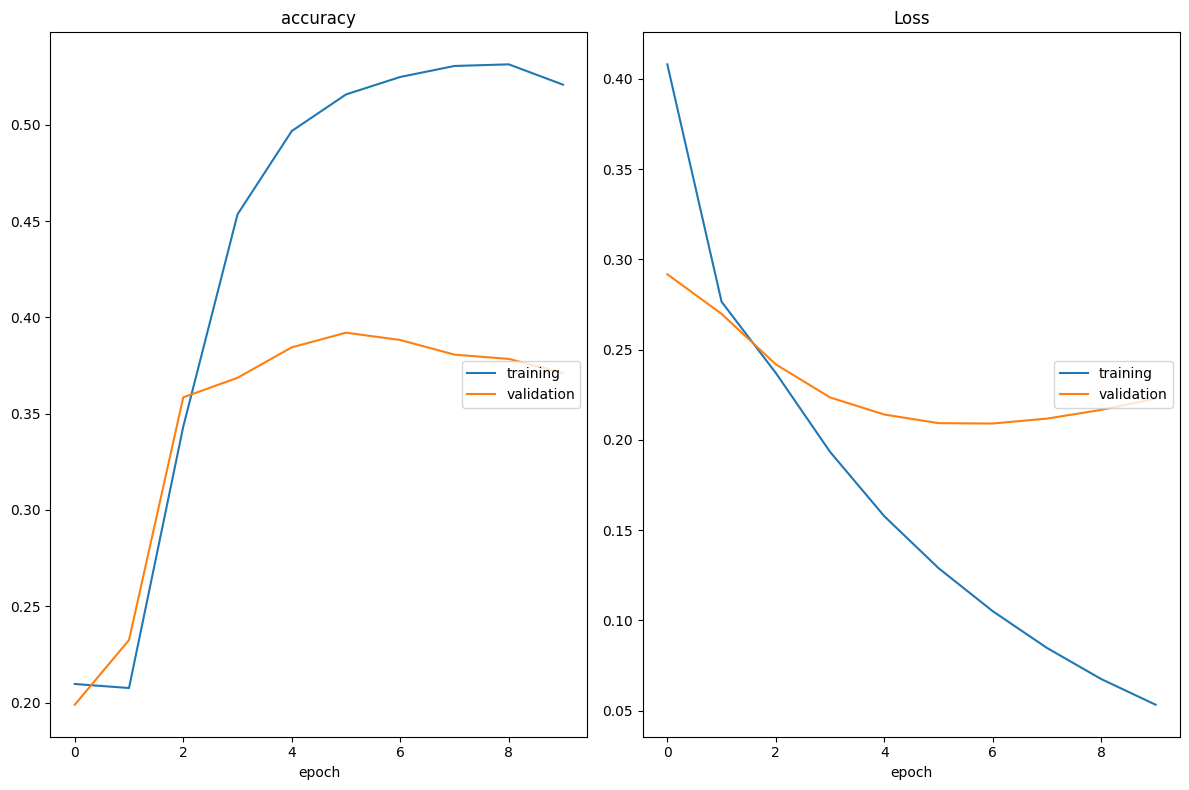

accuracy
	training         	 (min:    0.208, max:    0.531, cur:    0.521)
	validation       	 (min:    0.199, max:    0.392, cur:    0.371)
Loss
	training         	 (min:    0.053, max:    0.408, cur:    0.053)
	validation       	 (min:    0.209, max:    0.292, cur:    0.223)
149/149 - 4s - loss: 0.0533 - accuracy: 0.5208 - val_loss: 0.2229 - val_accuracy: 0.3711 - 4s/epoch - 29ms/step


In [24]:
# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras()])

In [79]:
# Predicción del modelo de clasificación
y_pred_genres = model.predict(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

99/99 [==============================] - 1s 5ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2606, 3158]

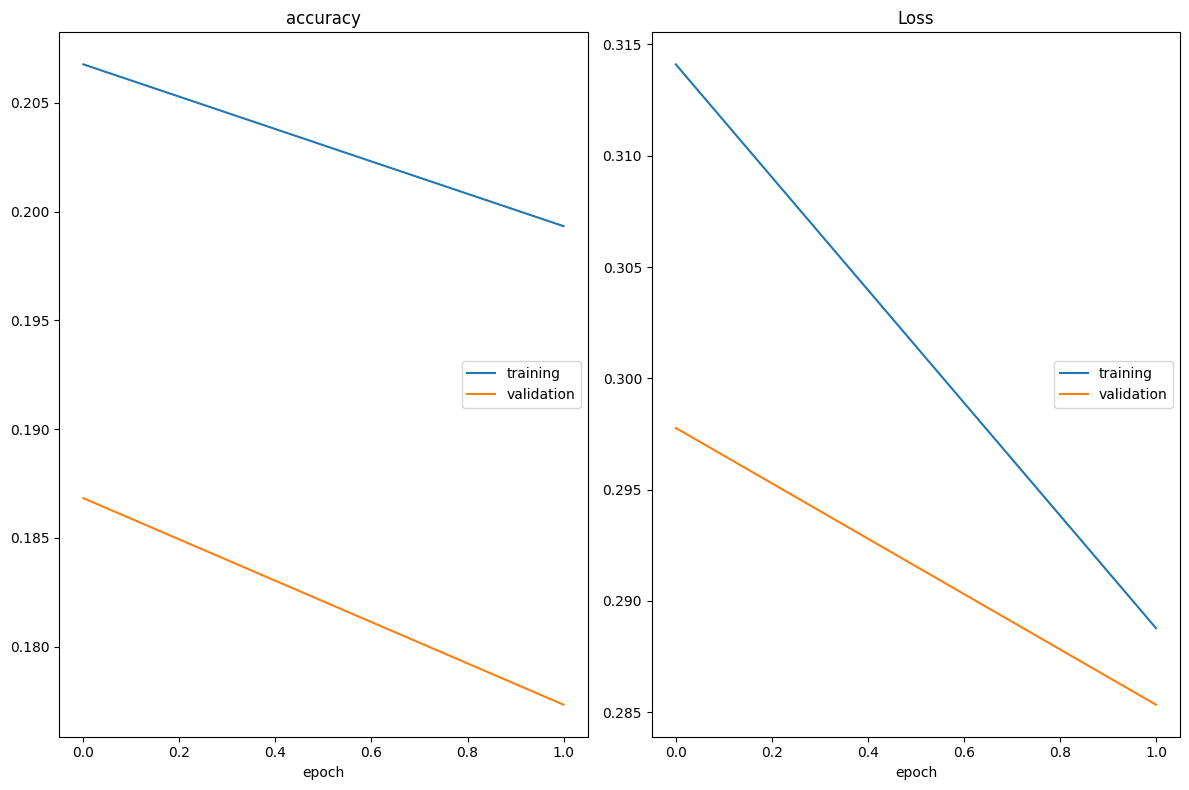

accuracy
	training         	 (min:    0.199, max:    0.207, cur:    0.199)
	validation       	 (min:    0.177, max:    0.187, cur:    0.177)
Loss
	training         	 (min:    0.289, max:    0.314, cur:    0.289)
	validation       	 (min:    0.285, max:    0.298, cur:    0.285)
198/198 - 37s - loss: 0.2888 - accuracy: 0.1993 - val_loss: 0.2853 - val_accuracy: 0.1773 - 37s/epoch - 186ms/step
Epoch 3/20


KeyboardInterrupt: 

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

# Preprocesamiento de texto
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataTraining['plot_lemmatized'])
X_sequences = tokenizer.texts_to_sequences(dataTraining['plot_lemmatized'])
X_padded = pad_sequences(X_sequences, maxlen=100)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_genres, test_size=0.2, random_state=42)

K.clear_session()
# Construcción del modelo
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Dropout del 50%
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_genres.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, PlotLossesKeras()])

# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


## Testeo del modelo

In [ ]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

KeyboardInterrupt: 